# Notebook 01 — Exploratory Data Analysis

**Dataset:** UCI Bank Marketing (`bank-additional-full.csv`)

**Purpose:** Deep dive into data quality, distributions, correlations, target analysis,
and business insights. Run sections as separate cells in Jupyter.

This notebook is organized into sections: data loading, basic statistics, missing values,
feature distributions, correlations, and target analysis. Use the code cells to
reproduce each step.

In [1]:
# === CELL 1: Imports and Configuration ===
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["figure.dpi"] = 120

In [3]:
# Add project root to path so we can import src modules
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [4]:
# === Download UCI Bank Marketing data (run once) ===
# Source: https://archive.ics.uci.edu/dataset/222/bank+marketing
import io
import urllib.request
import zipfile

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_RAW.mkdir(parents=True, exist_ok=True)

if not (DATA_RAW / "bank-additional-full.csv").exists():
    url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
    print("Downloading Bank Marketing dataset from UCI...")
    with urllib.request.urlopen(url) as resp:
        outer_zip = zipfile.ZipFile(io.BytesIO(resp.read()), "r")
        # Outer zip contains bank.zip and bank-additional.zip; we need CSVs from bank-additional
        inner_zip_data = outer_zip.read("bank-additional.zip")
    with zipfile.ZipFile(io.BytesIO(inner_zip_data), "r") as inner:
        for name in inner.namelist():
            if name.endswith(".csv"):
                (DATA_RAW / Path(name).name).write_bytes(inner.read(name))
    print("Done. Files in data/raw:", list(DATA_RAW.glob("*.csv")))
else:
    print("data/raw/bank-additional-full.csv already exists; skip download.")

data/raw/bank-additional-full.csv already exists; skip download.


In [5]:
# === CELL 2: Load Raw Data ===
#from src.data.ingest import load_raw_data

csv_path = PROJECT_ROOT / "data" / "raw" / "bank-additional-full.csv"
# UCI Bank Marketing uses semicolon (;) as delimiter (European format)
df = pd.read_csv(csv_path, sep=";")
pd.set_option("display.max_columns", None)  # show all columns in head() / display
print(f"Shape: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
df.head()

Shape: (41188, 21)
Memory: 28.1 MB


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# === CELL 3: Basic Info ===
print("=" * 60)
print("DATA TYPES")
print("=" * 60)
print(df.dtypes)
print(f"\nNumeric columns: {df.select_dtypes(include='number').columns.tolist()}")
print(f"Categorical columns: {df.select_dtypes(include='object').columns.tolist()}")

DATA TYPES
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


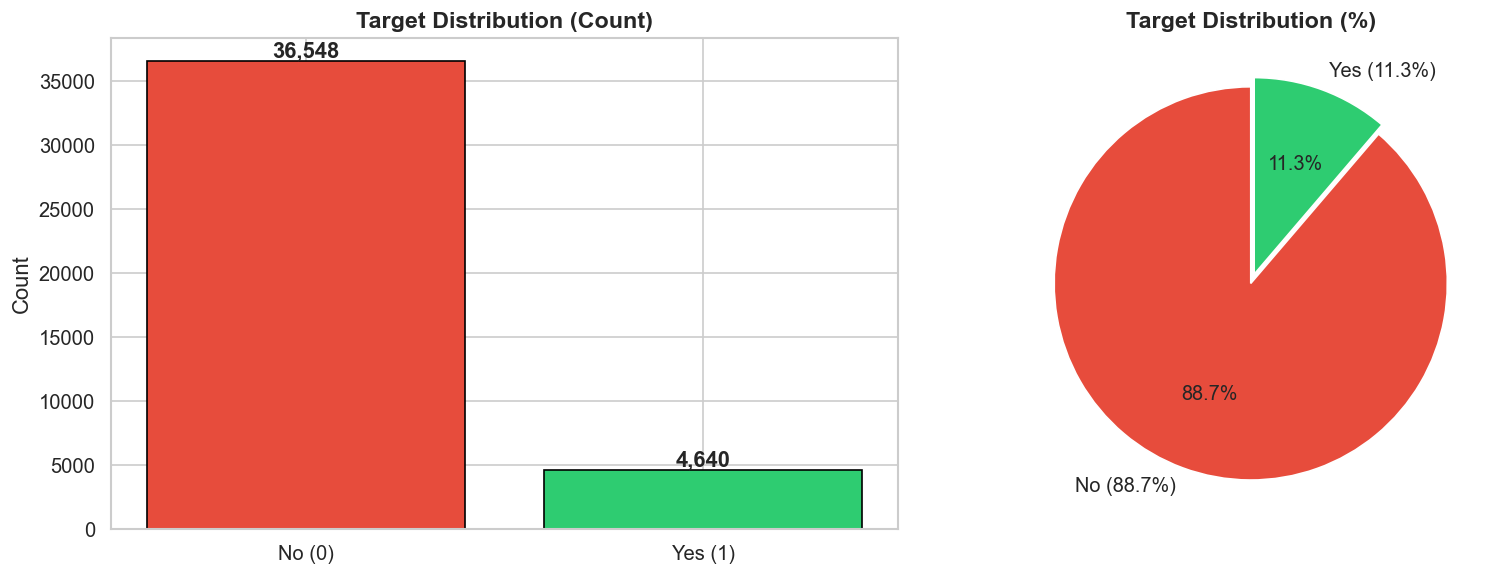


CLASS IMBALANCE: Only 11.3% positive class
   → Must use stratified splits, class weights, or SMOTE


In [7]:
# === CELL 4: Target Distribution ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts = df["y"].value_counts()
colors = ["#e74c3c", "#2ecc71"]
axes[0].bar(["No (0)", "Yes (1)"], target_counts.values, color=colors, edgecolor="black")
axes[0].set_title("Target Distribution (Count)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Count")
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 300, f"{v:,}", ha="center", fontweight="bold")

# Percentage
pct = df["y"].value_counts(normalize=True) * 100
axes[1].pie(pct.values, labels=[f"No ({pct.iloc[0]:.1f}%)", f"Yes ({pct.iloc[1]:.1f}%)"],
            colors=colors, autopct="%1.1f%%", startangle=90, explode=(0, 0.05),
            textprops={"fontsize": 12})
axes[1].set_title("Target Distribution (%)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "target_distribution.png", bbox_inches="tight")
plt.show()

print(f"\nCLASS IMBALANCE: Only {pct.iloc[1]:.1f}% positive class")
print("   → Must use stratified splits, class weights, or SMOTE")

'UNKNOWN' VALUE ANALYSIS (This dataset uses 'unknown' strings, NOT NaN)
   column  n_unknown  pct_unknown  n_unique_values
  default       8597        20.87                3
education       1731         4.20                8
  housing        990         2.40                3
     loan        990         2.40                3
      job        330         0.80               12
  marital         80         0.19                4


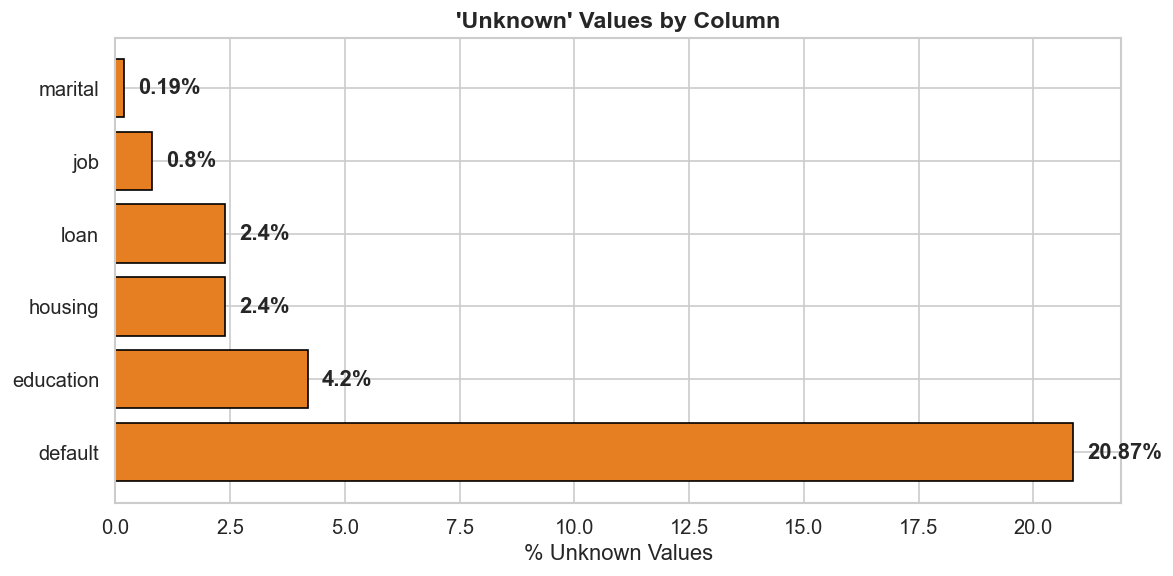


CLEANING STRATEGY:
  • job (0.8%), marital (0.2%), housing (2.4%), loan (2.4%) → Impute with MODE
  • education (4.2%) → Keep 'unknown' as category (may be informative)
  • default (20.9%) → Keep 'unknown' as category (too many to drop)


In [8]:
# === CELL 5: Missing Values / 'unknown' Analysis ===
print("=" * 60)
print("'UNKNOWN' VALUE ANALYSIS (This dataset uses 'unknown' strings, NOT NaN)")
print("=" * 60)

unknown_analysis = []
for col in df.select_dtypes(include="object").columns:
    n_unknown = (df[col] == "unknown").sum()
    if n_unknown > 0:
        pct_unknown = n_unknown / len(df) * 100
        unknown_analysis.append({
            "column": col,
            "n_unknown": n_unknown,
            "pct_unknown": round(pct_unknown, 2),
            "n_unique_values": df[col].nunique(),
        })

unknown_df = pd.DataFrame(unknown_analysis).sort_values("pct_unknown", ascending=False)
print(unknown_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(unknown_df["column"], unknown_df["pct_unknown"], color="#e67e22", edgecolor="black")
ax.set_xlabel("% Unknown Values")
ax.set_title("'Unknown' Values by Column", fontsize=14, fontweight="bold")
for bar, pct in zip(bars, unknown_df["pct_unknown"]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
            f"{pct}%", va="center", fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "unknown_values.png", bbox_inches="tight")
plt.show()

print("\nCLEANING STRATEGY:")
print("  • job (0.8%), marital (0.2%), housing (2.4%), loan (2.4%) → Impute with MODE")
print("  • education (4.2%) → Keep 'unknown' as category (may be informative)")
print("  • default (20.9%) → Keep 'unknown' as category (too many to drop)")

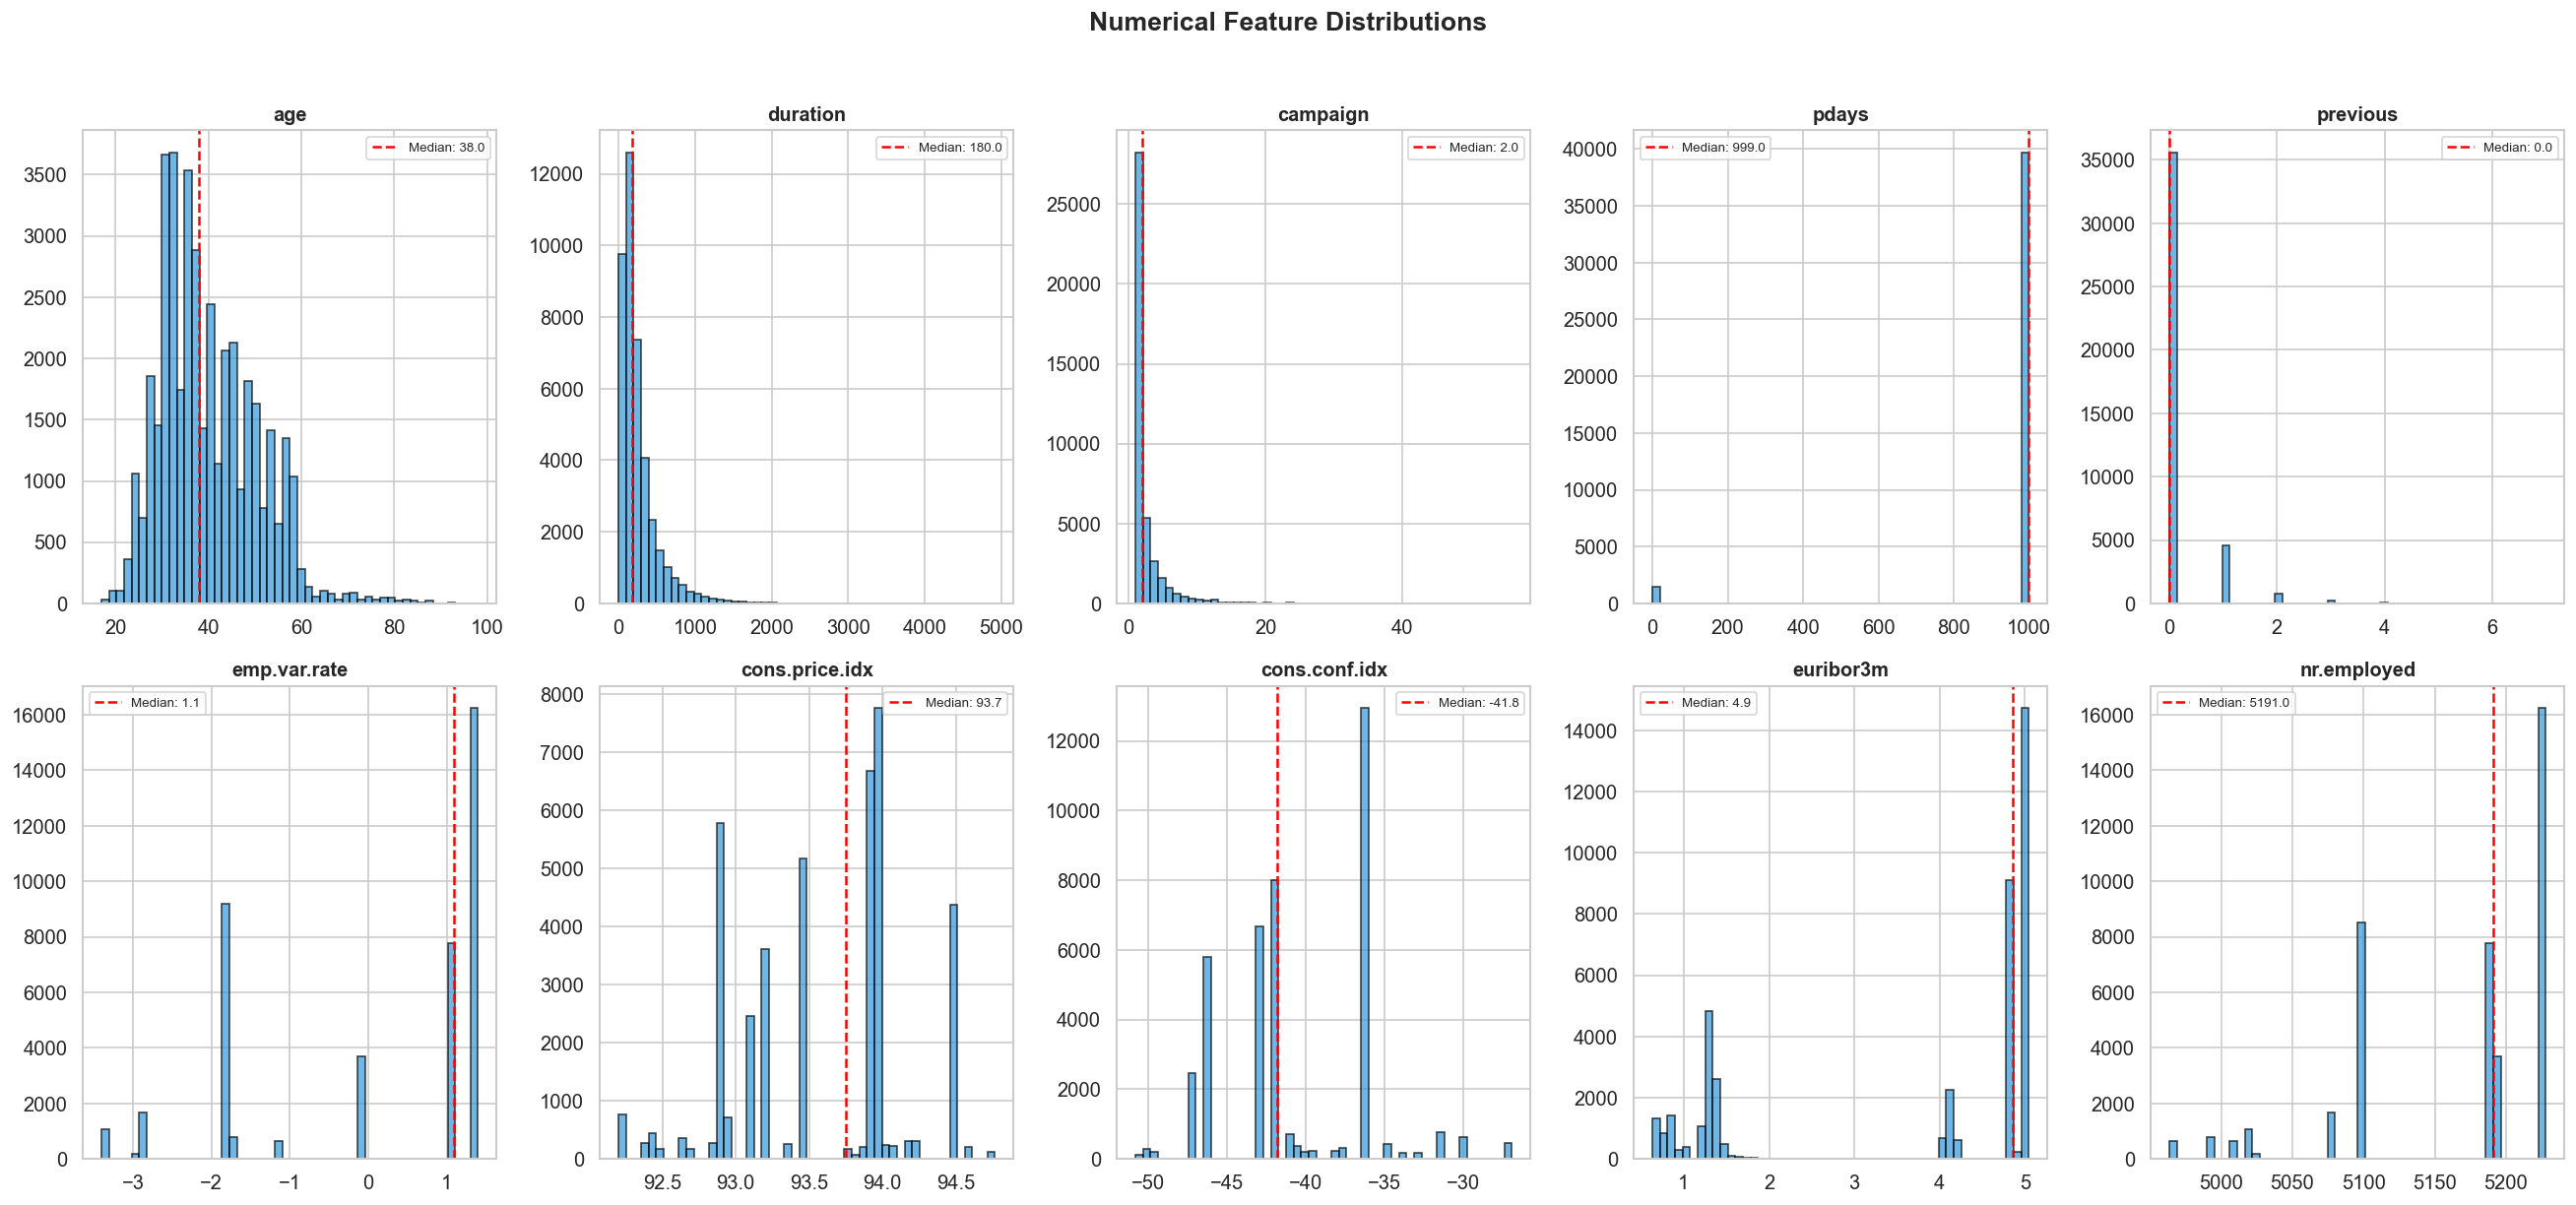

DESCRIPTIVE STATISTICS — NUMERICAL FEATURES
                  count     mean     std      min      25%      50%      75%      max  skewness  kurtosis
age             41188.0    40.02   10.42    17.00    32.00    38.00    47.00    98.00      0.78      0.79
duration        41188.0   258.29  259.28     0.00   102.00   180.00   319.00  4918.00      3.26     20.25
campaign        41188.0     2.57    2.77     1.00     1.00     2.00     3.00    56.00      4.76     36.98
pdays           41188.0   962.48  186.91     0.00   999.00   999.00   999.00   999.00     -4.92     22.23
previous        41188.0     0.17    0.49     0.00     0.00     0.00     0.00     7.00      3.83     20.11
emp.var.rate    41188.0     0.08    1.57    -3.40    -1.80     1.10     1.40     1.40     -0.72     -1.06
cons.price.idx  41188.0    93.58    0.58    92.20    93.08    93.75    93.99    94.77     -0.23     -0.83
cons.conf.idx   41188.0   -40.50    4.63   -50.80   -42.70   -41.80   -36.40   -26.90      0.30     -0.36
eu

In [9]:
# === CELL 6: Numerical Feature Distributions ===
num_cols = ["age", "duration", "campaign", "pdays", "previous",
            "emp.var.rate", "cons.price.idx", "cons.conf.idx",
            "euribor3m", "nr.employed"]

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    df[col].hist(bins=50, ax=ax, color="#3498db", edgecolor="black", alpha=0.7)
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.axvline(df[col].median(), color="red", linestyle="--", linewidth=1.5, label=f"Median: {df[col].median():.1f}")
    ax.legend(fontsize=8)

plt.suptitle("Numerical Feature Distributions", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "numerical_distributions.png", bbox_inches="tight")
plt.show()

# %%
# === CELL 7: Descriptive Statistics ===
print("=" * 60)
print("DESCRIPTIVE STATISTICS — NUMERICAL FEATURES")
print("=" * 60)
stats = df[num_cols].describe().T
stats["skewness"] = df[num_cols].skew()
stats["kurtosis"] = df[num_cols].kurtosis()
print(stats.round(2).to_string())

print("\nKEY OBSERVATIONS:")
print("  • pdays: 96.3% are 999 (sentinel for 'never contacted') → Needs transformation")
print("  • campaign: Right-skewed, most clients contacted 1-3 times")
print("  • duration: Strong predictor BUT is post-hoc → EXCLUDE from production model")

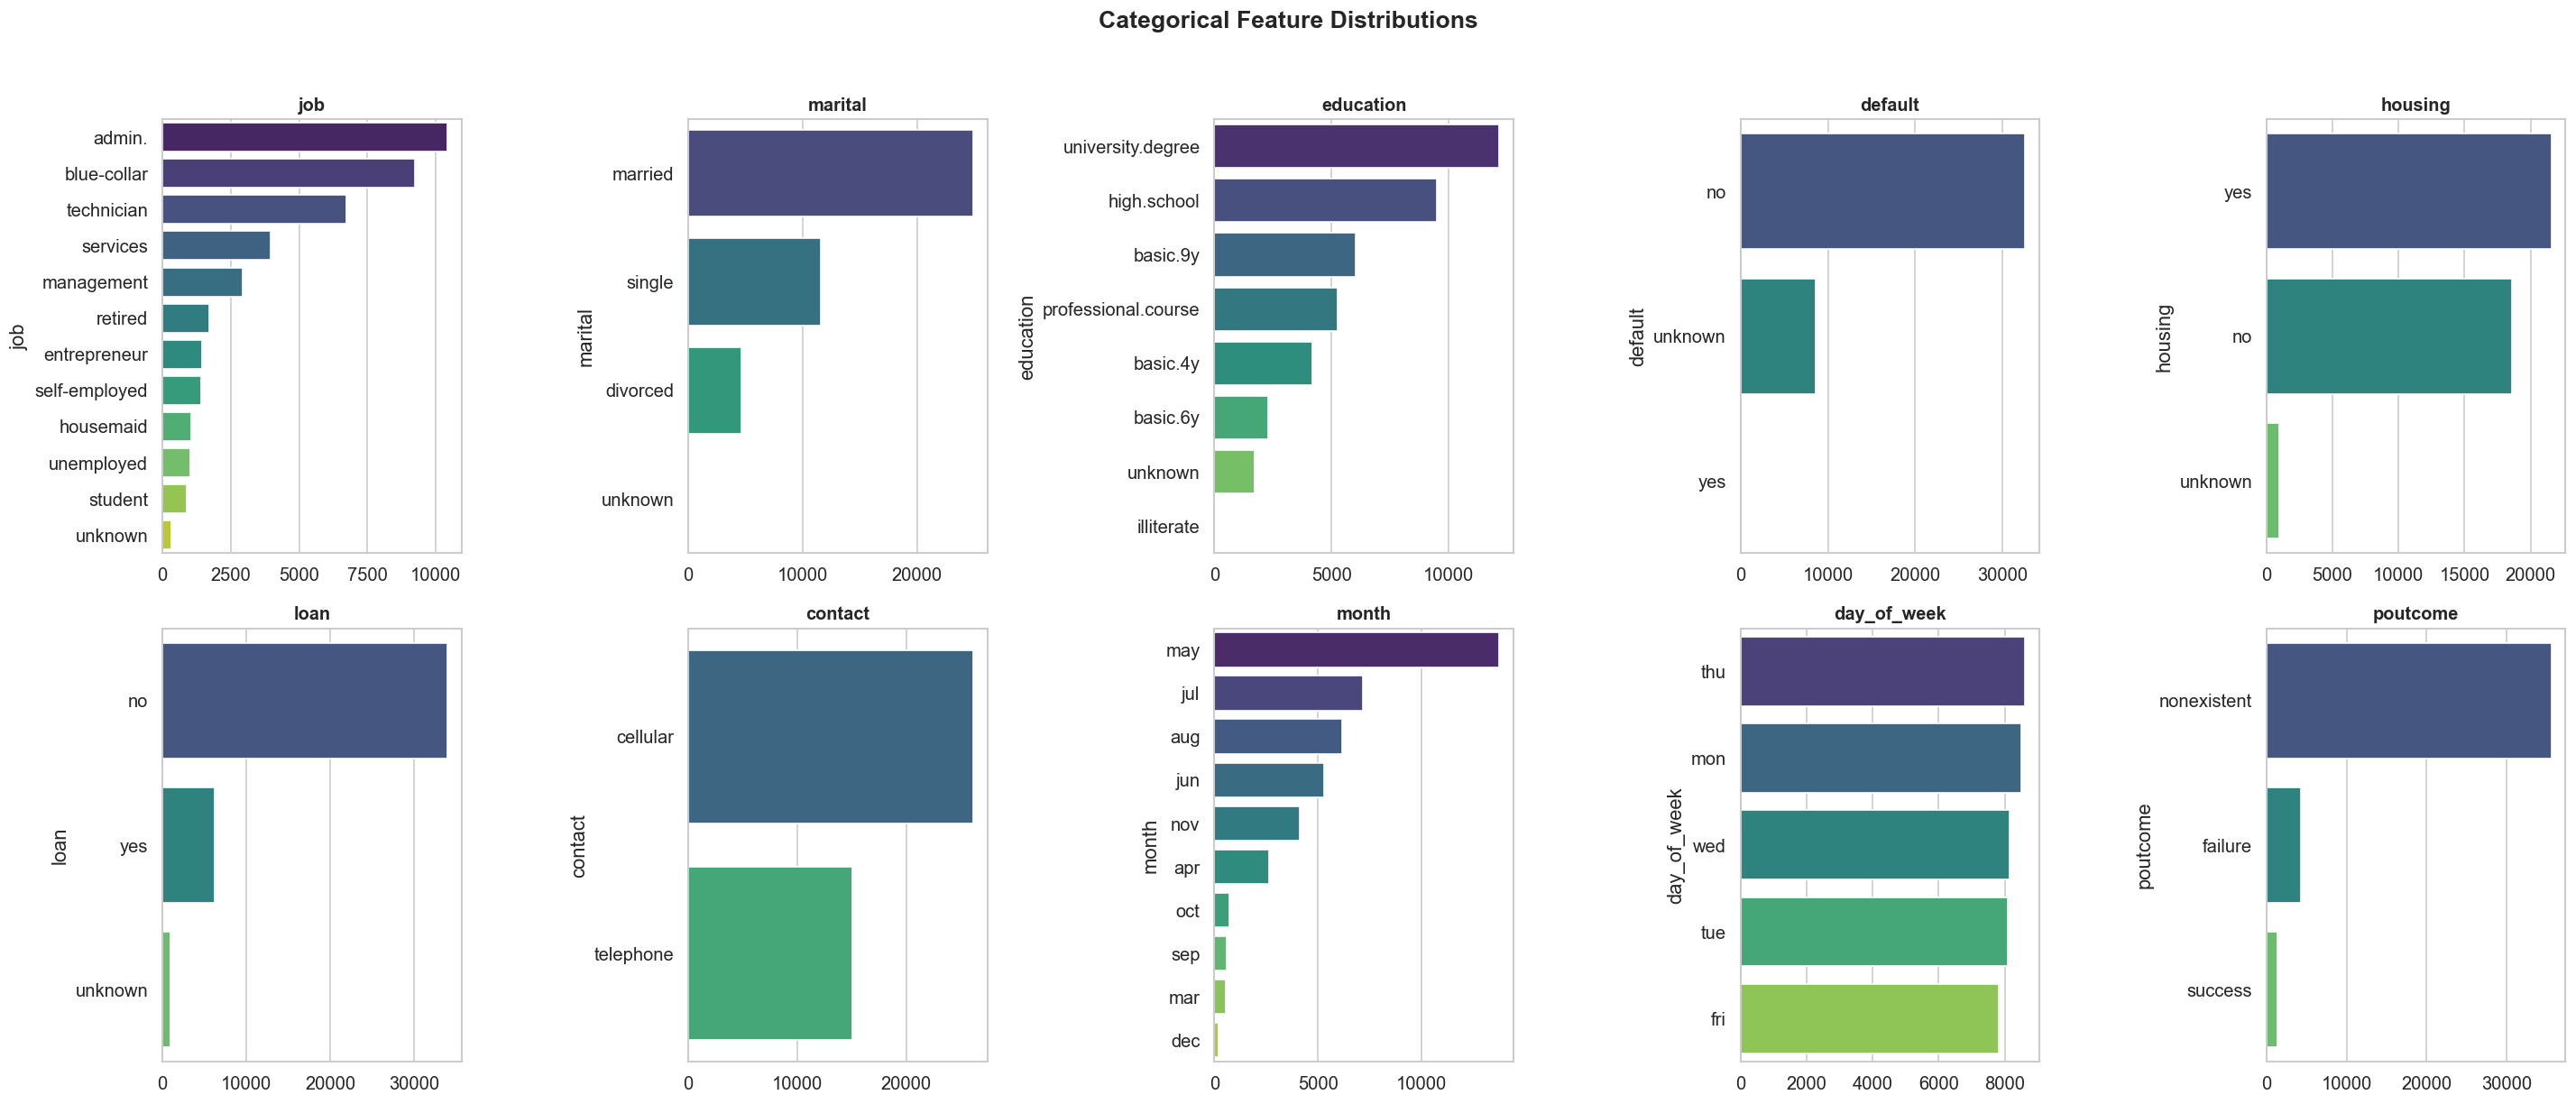

In [10]:
# === CELL 8: Categorical Feature Analysis ===
cat_cols = ["job", "marital", "education", "default", "housing",
            "loan", "contact", "month", "day_of_week", "poutcome"]

fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    order = df[col].value_counts().index
    sns.countplot(data=df, y=col, order=order, ax=ax, palette="viridis")
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_xlabel("")

plt.suptitle("Categorical Feature Distributions", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "categorical_distributions.png", bbox_inches="tight")
plt.show()

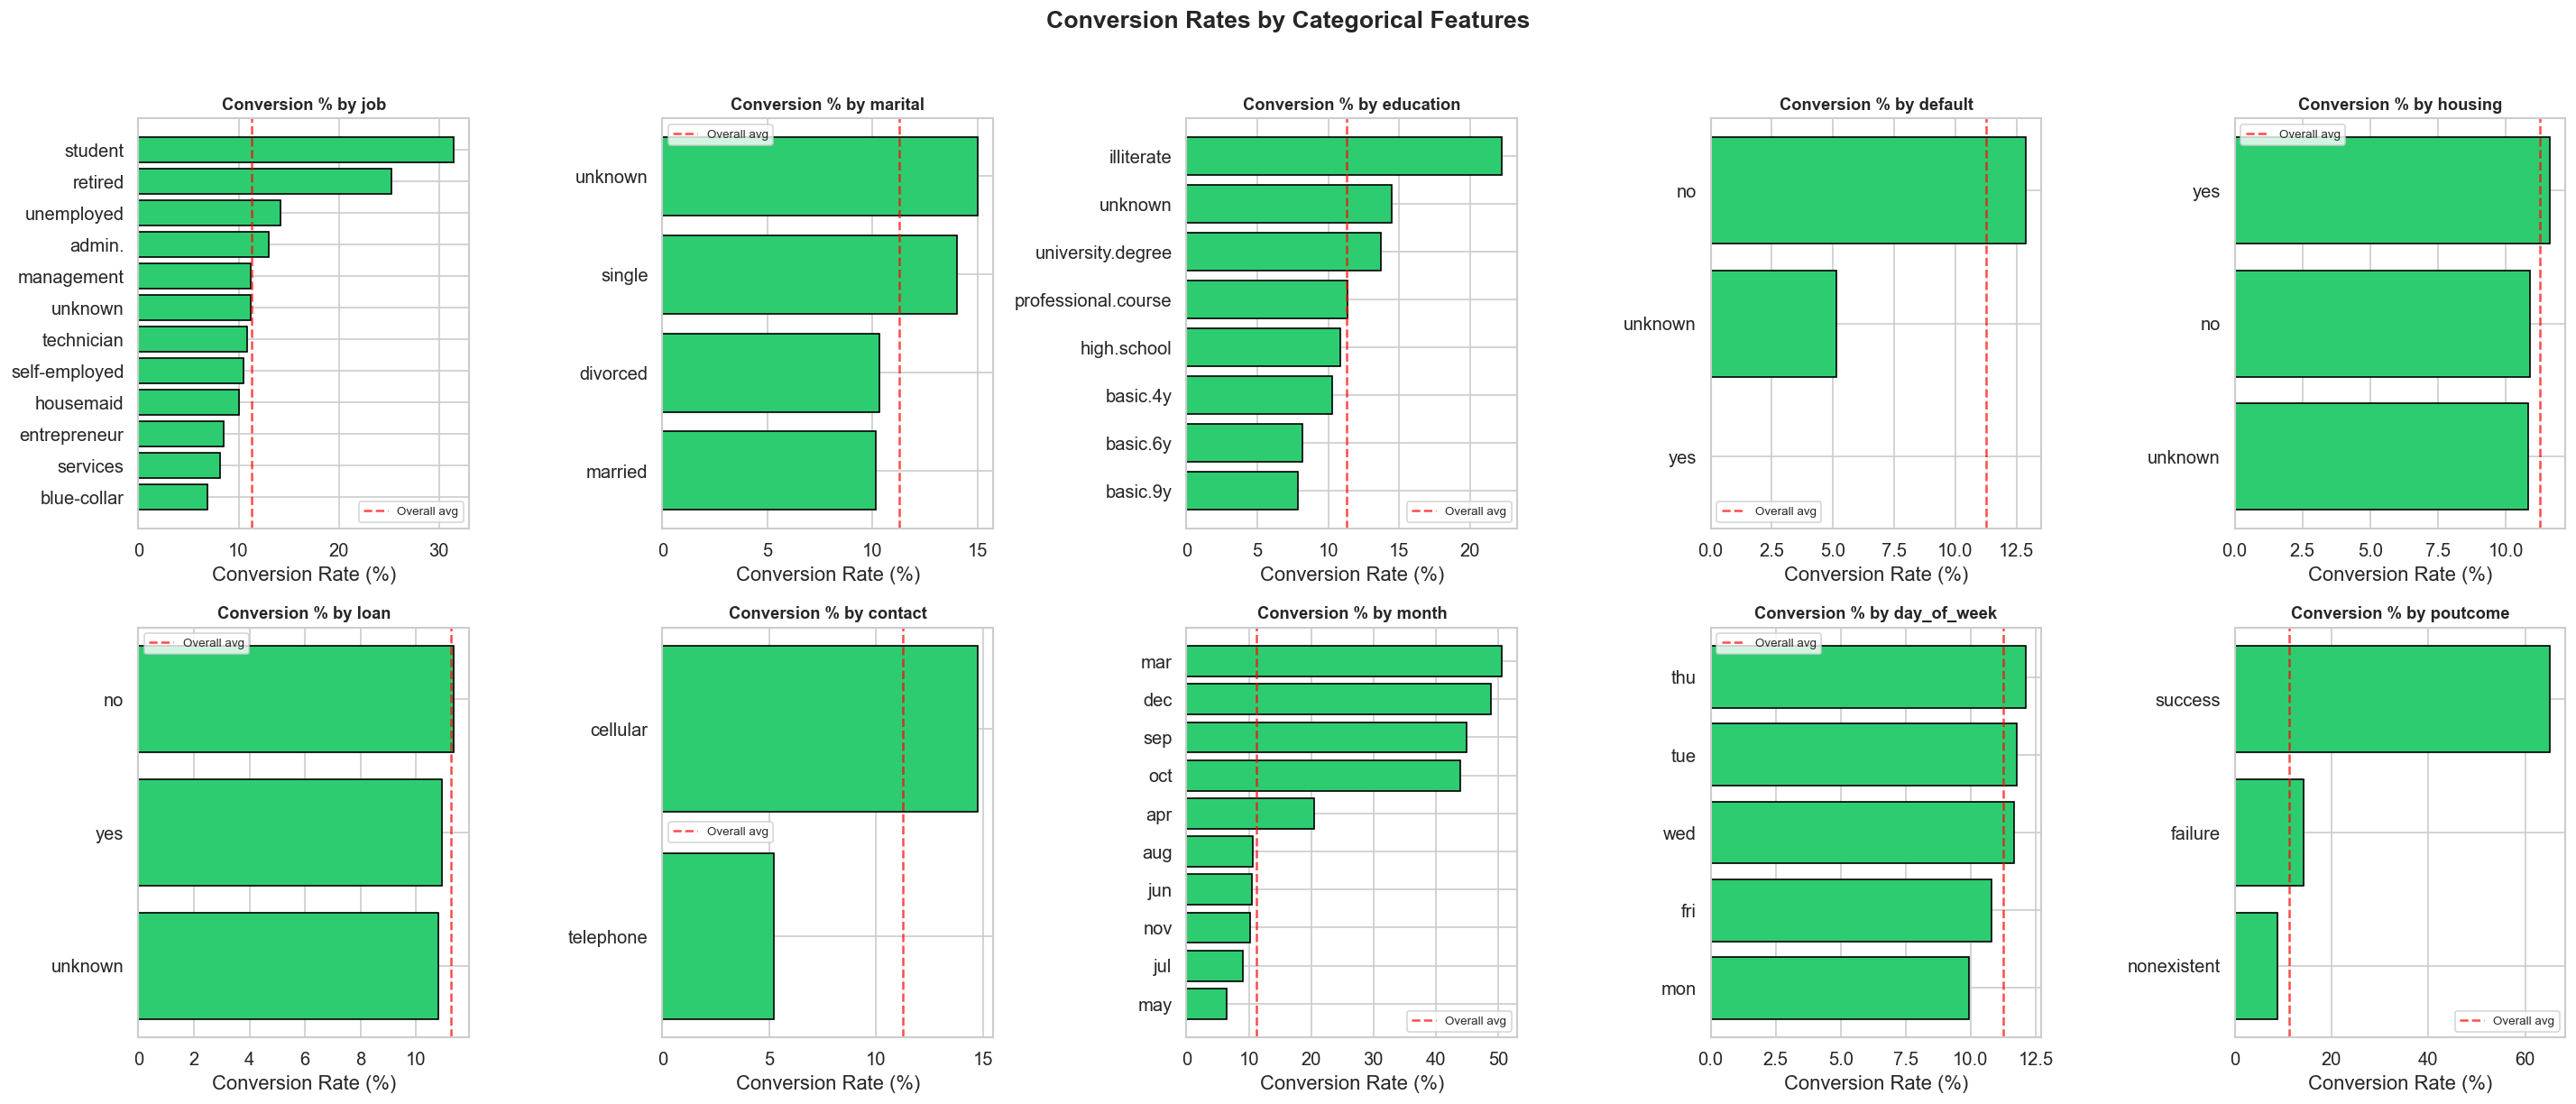

KEY BUSINESS INSIGHTS:
  • Students and retirees have highest conversion rates
  • poutcome='success' is by far the strongest predictor (>60% conversion)
  • Cellular contact outperforms telephone significantly
  • March, September, October, December show higher conversion rates


In [11]:
# === CELL 9: Conversion Rate by Categorical Features ===
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    # y is "yes"/"no" → conversion rate = proportion of "yes"
    conv_rate = (df["y"] == "yes").groupby(df[col]).mean().sort_values(ascending=True)
    bars = ax.barh(conv_rate.index, conv_rate.values * 100, color="#2ecc71", edgecolor="black")
    ax.set_title(f"Conversion % by {col}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Conversion Rate (%)")
    ax.axvline((df["y"] == "yes").mean() * 100, color="red", linestyle="--", alpha=0.7, label="Overall avg")
    ax.legend(fontsize=8)

plt.suptitle("Conversion Rates by Categorical Features", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "conversion_by_category.png", bbox_inches="tight")
plt.show()

print("KEY BUSINESS INSIGHTS:")
print("  • Students and retirees have highest conversion rates")
print("  • poutcome='success' is by far the strongest predictor (>60% conversion)")
print("  • Cellular contact outperforms telephone significantly")
print("  • March, September, October, December show higher conversion rates")

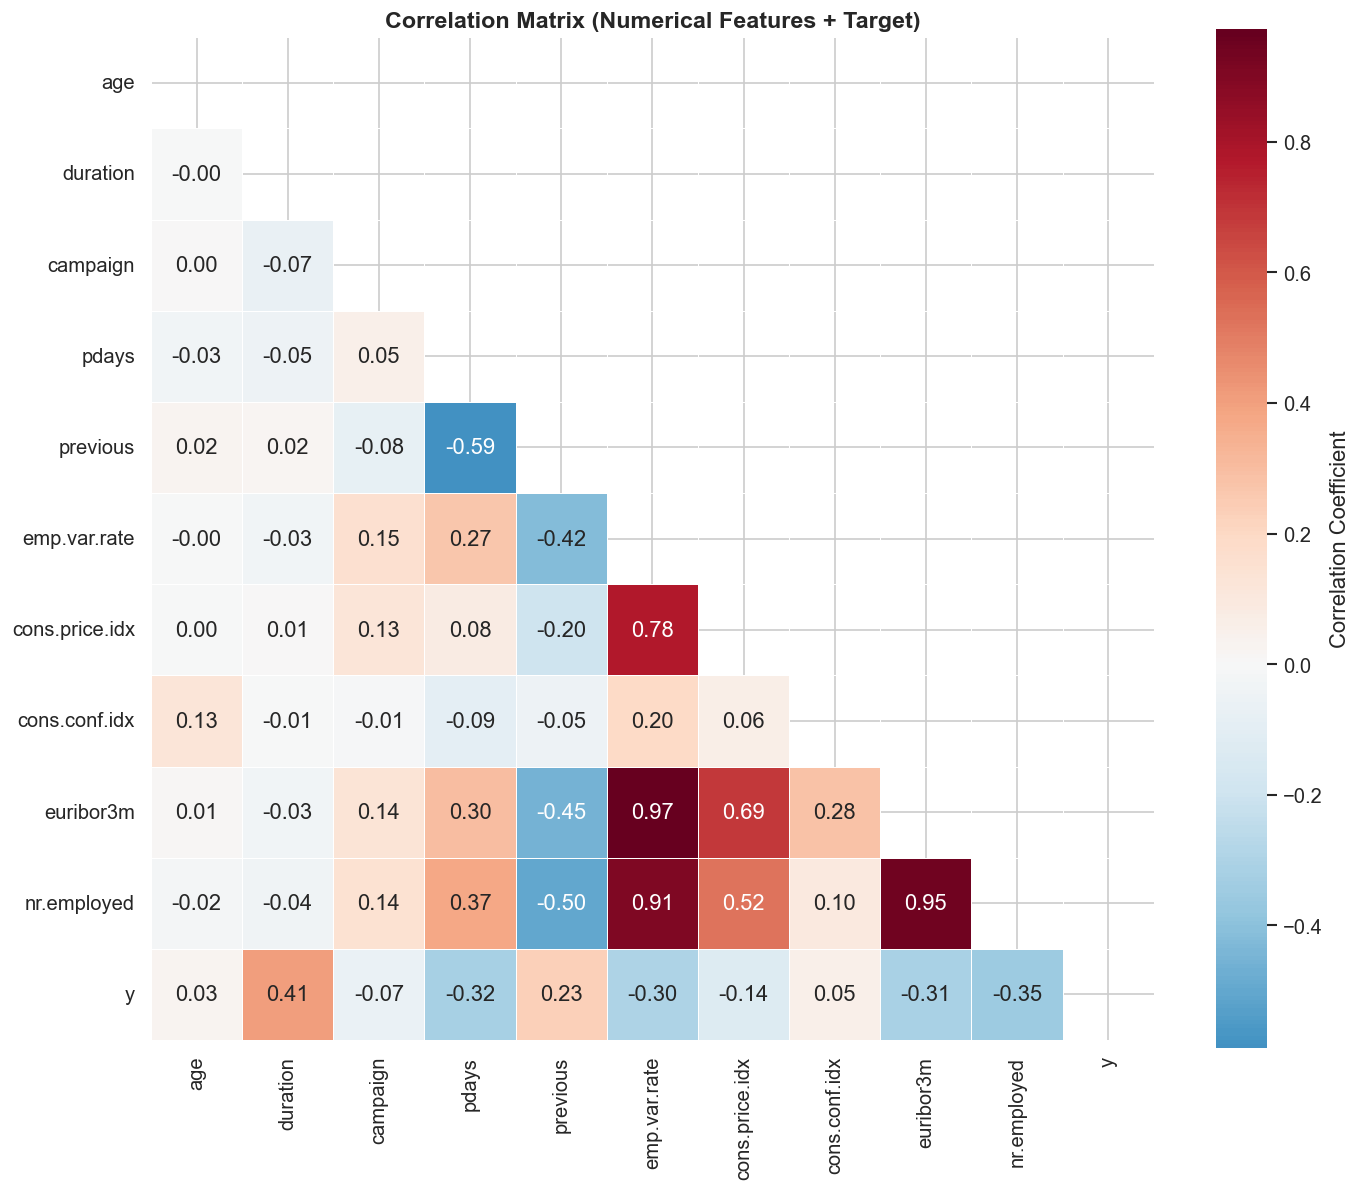

CORRELATION INSIGHTS:
  • duration ↔ y: strong (0.41) but CANNOT use in production
  • euribor3m ↔ nr.employed: very high correlation (0.95) — collinearity
  • emp.var.rate ↔ euribor3m: high correlation (0.97)
  • Macro-economic features are strongly intercorrelated → may need feature selection


In [12]:
# === CELL 10: Correlation Matrix (Numeric Features) ===
fig, ax = plt.subplots(figsize=(12, 10))

# Encode target "yes"/"no" as 1/0 for correlation
corr_df = df[num_cols].copy()
corr_df["y"] = (df["y"] == "yes").astype(int)
corr_matrix = corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={"label": "Correlation Coefficient"})
ax.set_title("Correlation Matrix (Numerical Features + Target)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "correlation_matrix.png", bbox_inches="tight")
plt.show()

print("CORRELATION INSIGHTS:")
print("  • duration ↔ y: strong (0.41) but CANNOT use in production")
print("  • euribor3m ↔ nr.employed: very high correlation (0.95) — collinearity")
print("  • emp.var.rate ↔ euribor3m: high correlation (0.97)")
print("  • Macro-economic features are strongly intercorrelated → may need feature selection")

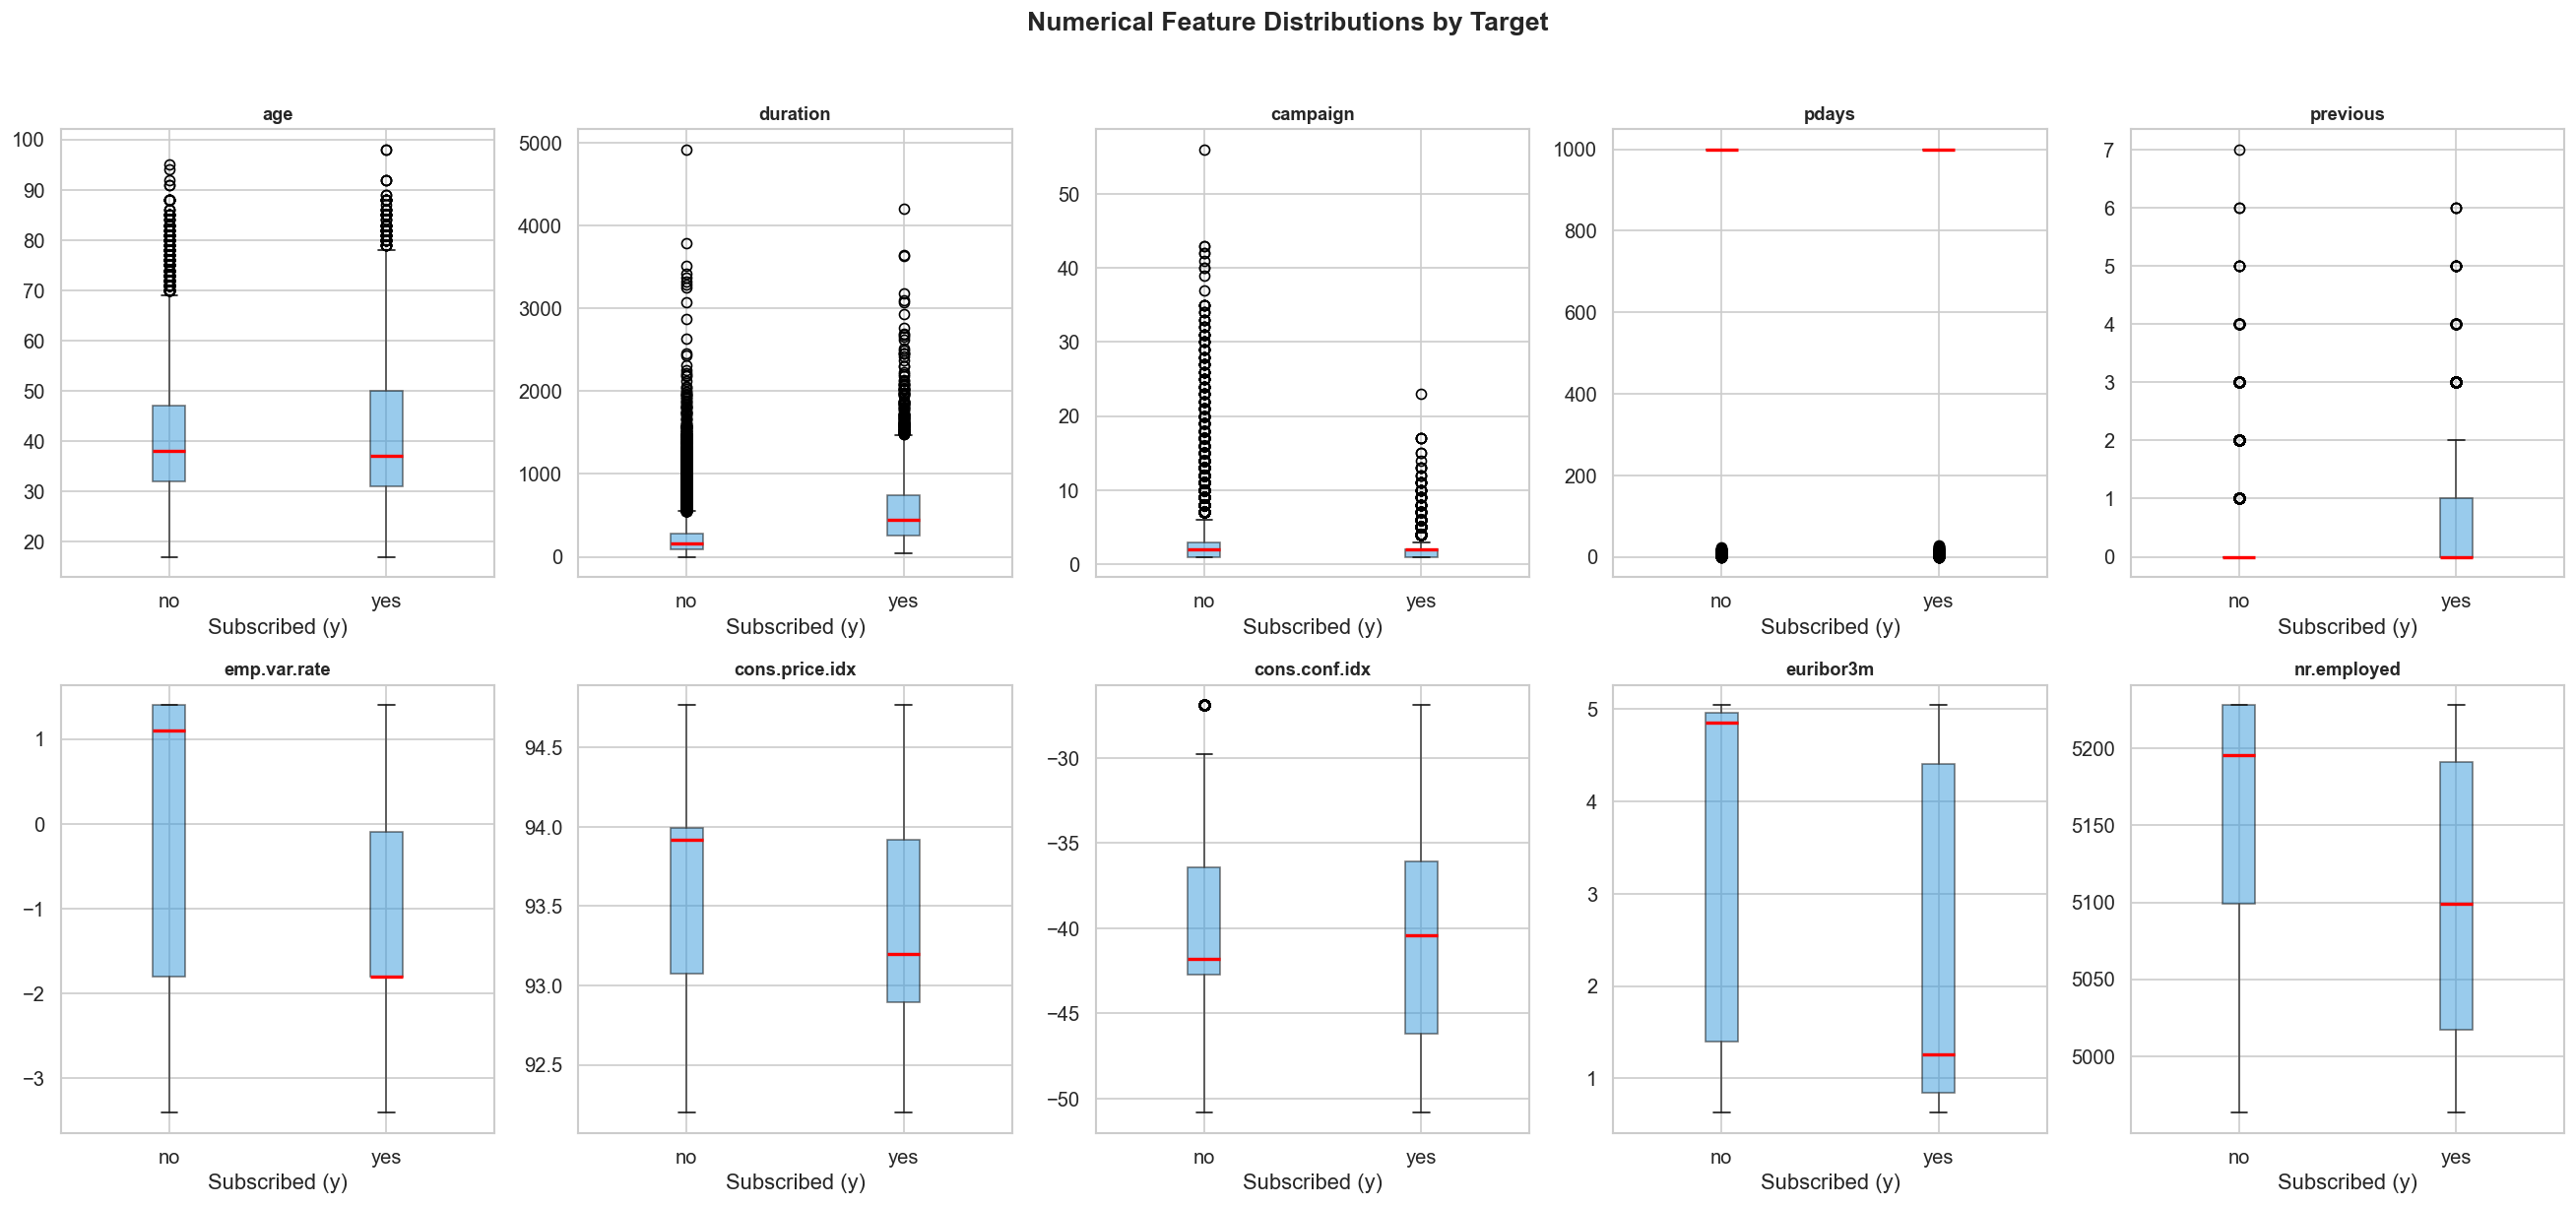

In [13]:
# === CELL 11: Numerical Features by Target Class ===
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    df.boxplot(column=col, by="y", ax=ax, patch_artist=True,
               boxprops=dict(facecolor="#3498db", alpha=0.5),
               medianprops=dict(color="red", linewidth=2))
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("Subscribed (y)")
    plt.suptitle("")

plt.suptitle("Numerical Feature Distributions by Target", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "boxplots_by_target.png", bbox_inches="tight")
plt.show()

PDAYS ANALYSIS
pdays=999 (never contacted): 96.3%

Conversion rate when pdays=999: 9.3%
Conversion rate when pdays≠999: 63.8%


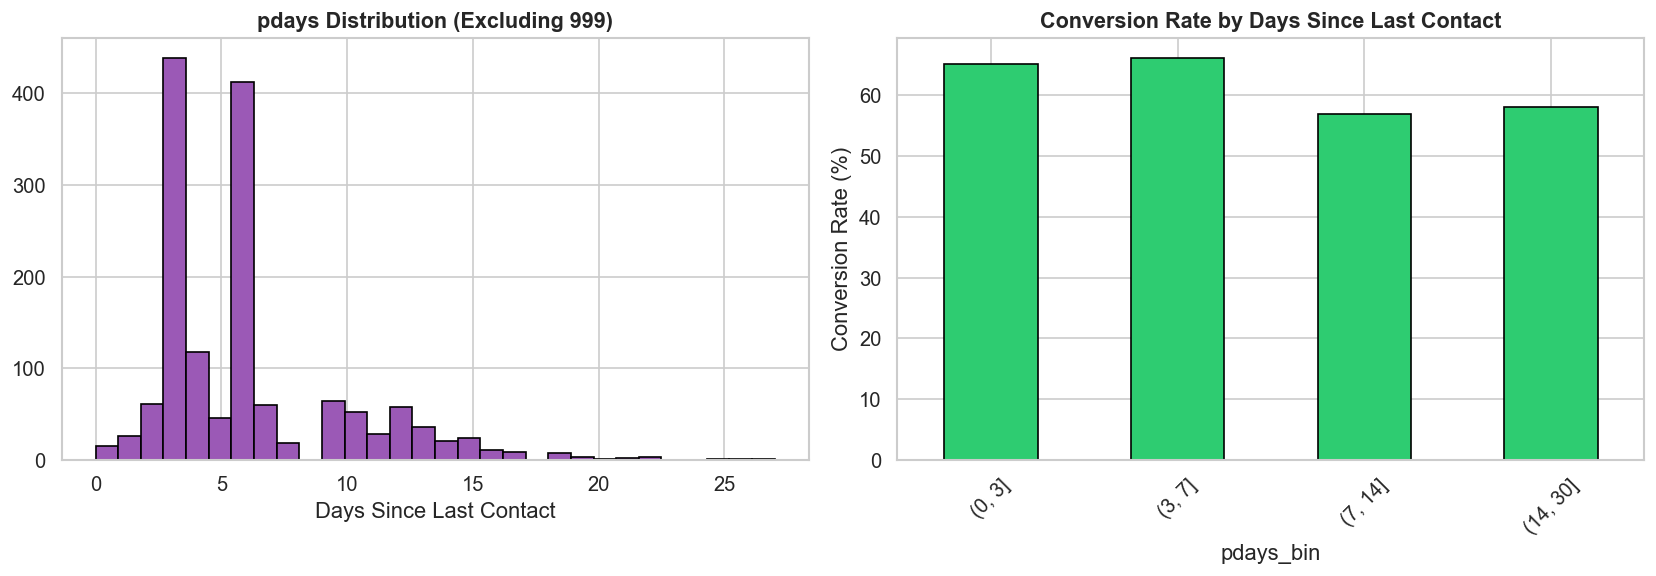


PDAYS STRATEGY:
  • 999 is a sentinel, not a real number → Create binary flag 'was_previously_contacted'
  • For non-999: log-transform (right-skewed)
  • Recent contact (1-3 days) has highest conversion rate


In [14]:
# === CELL 12: Pdays Deep Dive ===
print("=" * 60)
print("PDAYS ANALYSIS")
print("=" * 60)

pdays_dist = df["pdays"].value_counts(normalize=True).head()
print(f"pdays=999 (never contacted): {(df['pdays'] == 999).mean():.1%}")
print(f"\nConversion rate when pdays=999: {(df.loc[df['pdays'] == 999, 'y'] == 'yes').mean():.1%}")
print(f"Conversion rate when pdays≠999: {(df.loc[df['pdays'] != 999, 'y'] == 'yes').mean():.1%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of pdays (excluding 999)
contacted = df[df["pdays"] != 999]
axes[0].hist(contacted["pdays"], bins=30, color="#9b59b6", edgecolor="black")
axes[0].set_title("pdays Distribution (Excluding 999)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Days Since Last Contact")

# Conversion rate by pdays bins
contacted_copy = contacted.copy()
contacted_copy["pdays_bin"] = pd.cut(contacted_copy["pdays"], bins=[0, 3, 7, 14, 30, 999])
conv_by_pdays = (contacted_copy["y"] == "yes").groupby(contacted_copy["pdays_bin"], observed=True).mean() * 100
conv_by_pdays.plot(kind="bar", ax=axes[1], color="#2ecc71", edgecolor="black")
axes[1].set_title("Conversion Rate by Days Since Last Contact", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Conversion Rate (%)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "pdays_analysis.png", bbox_inches="tight")
plt.show()

print("\nPDAYS STRATEGY:")
print("  • 999 is a sentinel, not a real number → Create binary flag 'was_previously_contacted'")
print("  • For non-999: log-transform (right-skewed)")
print("  • Recent contact (1-3 days) has highest conversion rate")

CRITICAL: DURATION ANALYSIS (BENCHMARK ONLY)


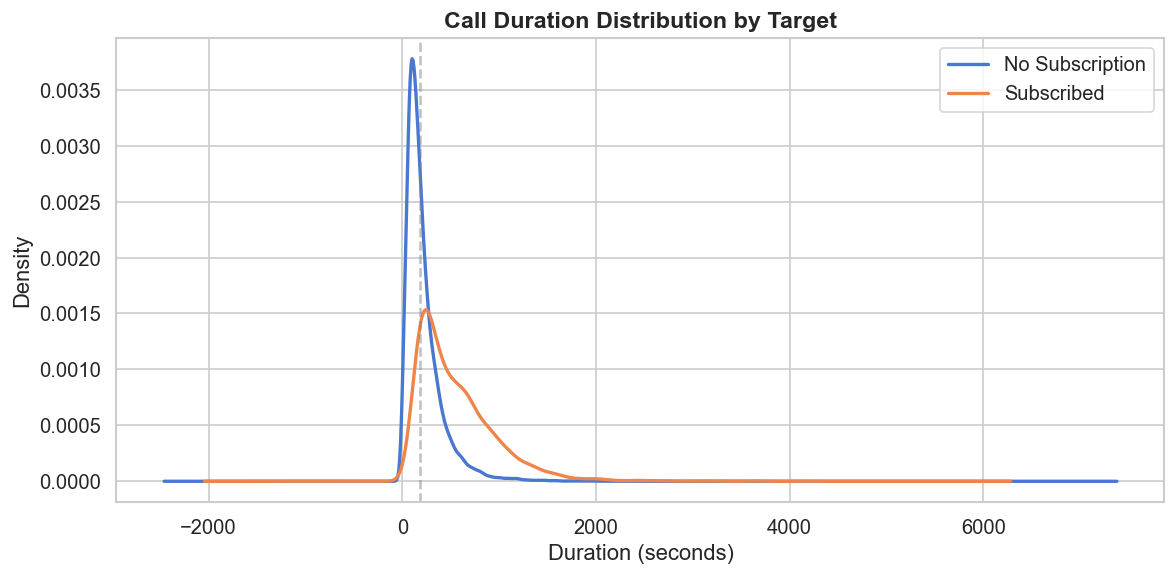

Correlation(duration, y) = 0.405

DURATION MUST BE EXCLUDED FROM PRODUCTION MODEL:
   - It is only known AFTER a call ends
   - Including it = data leakage = inflated metrics
   - UCI docs explicitly warn about this
   - We train TWO models: benchmark (with) and production (without)


In [15]:
# === CELL 13: Duration Warning ===
print("=" * 60)
print("CRITICAL: DURATION ANALYSIS (BENCHMARK ONLY)")
print("=" * 60)

fig, ax = plt.subplots(figsize=(10, 5))
df.groupby("y")["duration"].plot(kind="kde", ax=ax, linewidth=2)
ax.set_title("Call Duration Distribution by Target", fontsize=14, fontweight="bold")
ax.set_xlabel("Duration (seconds)")
ax.legend(["No Subscription", "Subscribed"])
ax.axvline(df["duration"].median(), color="gray", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_warning.png", bbox_inches="tight")
plt.show()

corr_duration_y = df["duration"].corr((df["y"] == "yes").astype(int))
print(f"Correlation(duration, y) = {corr_duration_y:.3f}")
print("\nDURATION MUST BE EXCLUDED FROM PRODUCTION MODEL:")
print("   - It is only known AFTER a call ends")
print("   - Including it = data leakage = inflated metrics")
print("   - UCI docs explicitly warn about this")
print("   - We train TWO models: benchmark (with) and production (without)")

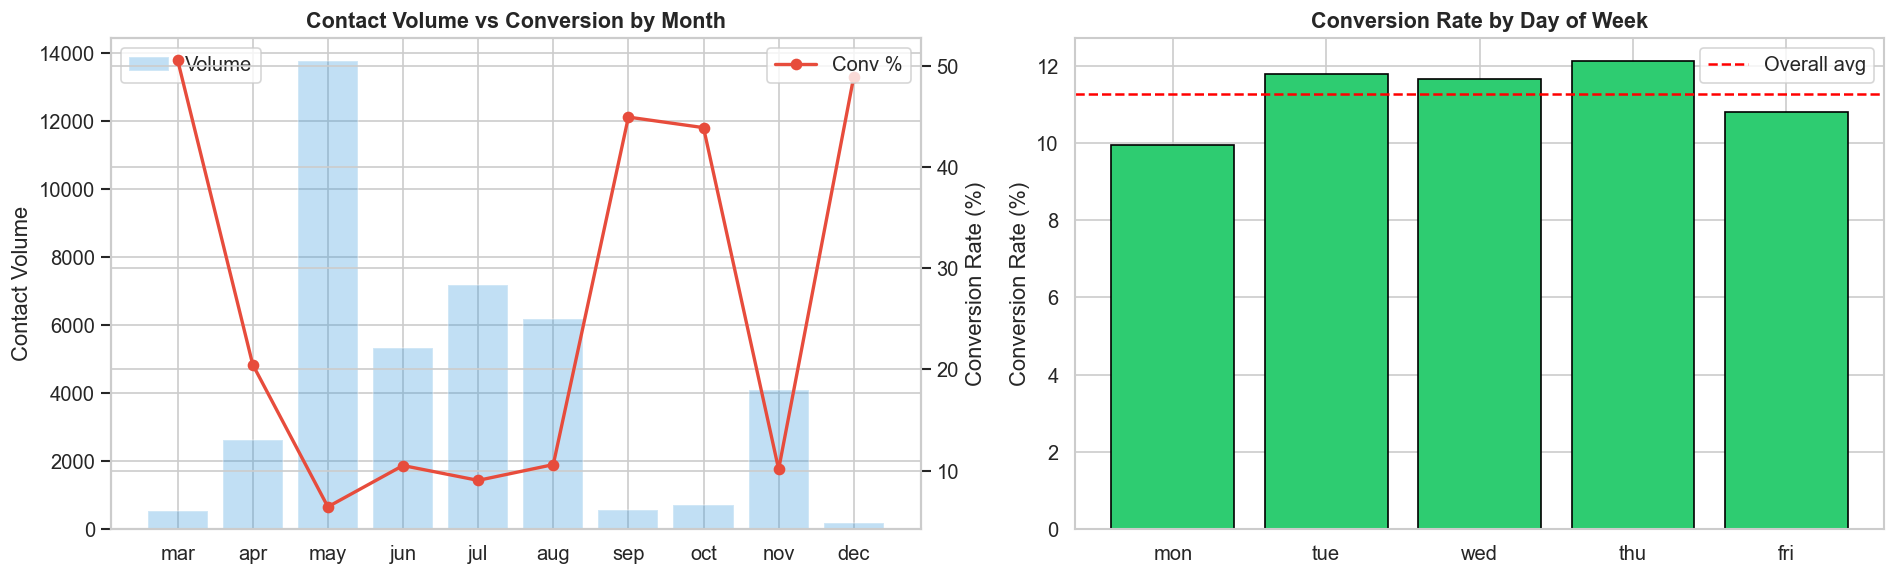

In [16]:
# === CELL 14: Month/Day Patterns ===
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Month order
month_order = ["jan", "feb", "mar", "apr", "may", "jun",
               "jul", "aug", "sep", "oct", "nov", "dec"]
# y is "yes"/"no" → mean = conversion rate (proportion of "yes")
month_conv = (df["y"] == "yes").groupby(df["month"]).agg(["mean", "count"]).reindex(month_order)

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.bar(month_conv.index, month_conv["count"], alpha=0.3, color="#3498db", label="Volume")
ax2.plot(month_conv.index, month_conv["mean"] * 100, "o-", color="#e74c3c", linewidth=2, label="Conv %")
ax1.set_title("Contact Volume vs Conversion by Month", fontsize=13, fontweight="bold")
ax1.set_ylabel("Contact Volume")
ax2.set_ylabel("Conversion Rate (%)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Day of week
day_order = ["mon", "tue", "wed", "thu", "fri"]
day_conv = (df["y"] == "yes").groupby(df["day_of_week"]).mean().reindex(day_order) * 100
axes[1].bar(day_conv.index, day_conv.values, color="#2ecc71", edgecolor="black")
axes[1].set_title("Conversion Rate by Day of Week", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Conversion Rate (%)")
axes[1].axhline((df["y"] == "yes").mean() * 100, color="red", linestyle="--", label="Overall avg")
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "temporal_patterns.png", bbox_inches="tight")
plt.show()

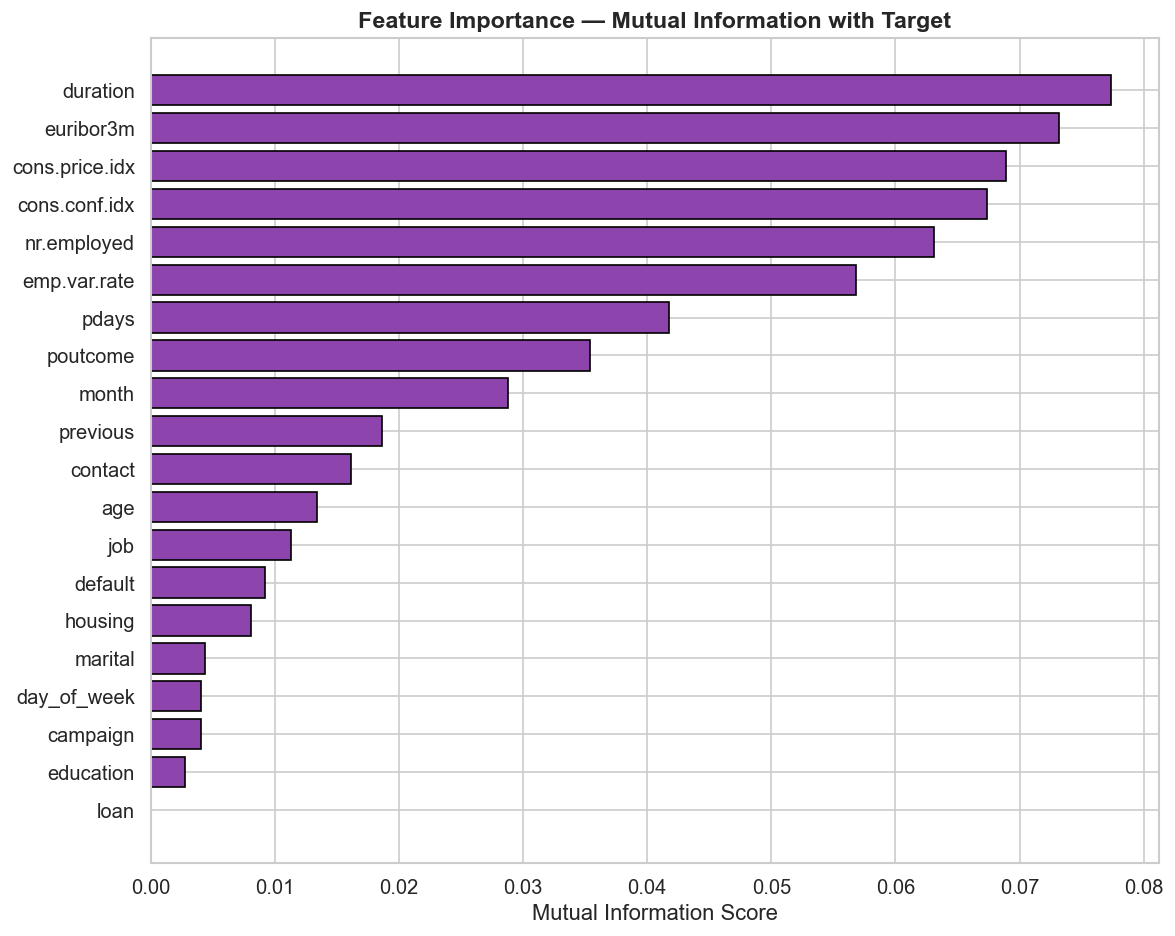

       feature  mutual_information
      duration            0.077351
     euribor3m            0.073186
cons.price.idx            0.068945
 cons.conf.idx            0.067400
   nr.employed            0.063110
  emp.var.rate            0.056823
         pdays            0.041711
      poutcome            0.035422
         month            0.028797
      previous            0.018647
       contact            0.016154
           age            0.013381
           job            0.011294
       default            0.009196
       housing            0.008090
       marital            0.004378
   day_of_week            0.004060
      campaign            0.004018
     education            0.002754
          loan            0.000000


In [17]:
# === CELL 15: Feature-Target Mutual Information ===
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Encode categoricals for MI calculation
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include="object").columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

X_mi = df_encoded.drop(columns=["y"])
y_mi = df_encoded["y"]

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_df = pd.DataFrame({
    "feature": X_mi.columns,
    "mutual_information": mi_scores
}).sort_values("mutual_information", ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(mi_df["feature"], mi_df["mutual_information"], color="#8e44ad", edgecolor="black")
ax.set_xlabel("Mutual Information Score")
ax.set_title("Feature Importance — Mutual Information with Target", fontsize=14, fontweight="bold")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "mutual_information.png", bbox_inches="tight")
plt.show()

print(mi_df.to_string(index=False))

In [18]:
# === CELL 16: EDA Summary ===
print("=" * 60)
print("EDA SUMMARY & RECOMMENDATIONS")
print("=" * 60)
print("""
1. TARGET IMBALANCE: 88.7% / 11.3% — use stratified splits + class_weight='balanced'
2. DURATION: Strongest predictor (MI=0.19) but MUST be excluded → data leakage
3. MACRO FEATURES: euribor3m, nr.employed, emp.var.rate are highly correlated
   → Consider PCA or dropping redundant features
4. PDAYS: 96.3% are sentinel value 999 → Transform to binary flag + log
5. UNKNOWN VALUES: default has 20.9% unknowns → keep as category
6. TOP PREDICTORS (excl. duration): euribor3m, nr.employed, poutcome, age, month
7. BUSINESS RULES:
   - Previously successful clients are 8x more likely to convert
   - Diminishing returns after 3 contacts per campaign
   - Students + retirees are best segments
   - Cellular > telephone for contact method
   - Best months: March, September, October, December
""")

EDA SUMMARY & RECOMMENDATIONS

1. TARGET IMBALANCE: 88.7% / 11.3% — use stratified splits + class_weight='balanced'
2. DURATION: Strongest predictor (MI=0.19) but MUST be excluded → data leakage
3. MACRO FEATURES: euribor3m, nr.employed, emp.var.rate are highly correlated
   → Consider PCA or dropping redundant features
4. PDAYS: 96.3% are sentinel value 999 → Transform to binary flag + log
5. UNKNOWN VALUES: default has 20.9% unknowns → keep as category
6. TOP PREDICTORS (excl. duration): euribor3m, nr.employed, poutcome, age, month
7. BUSINESS RULES:
   - Previously successful clients are 8x more likely to convert
   - Diminishing returns after 3 contacts per campaign
   - Students + retirees are best segments
   - Cellular > telephone for contact method
   - Best months: March, September, October, December

